In [1]:
#%%
import numpy as np
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import numba as nb
import sys
import os

sys.path.insert(0, os.path.realpath('./transport/'))

from transport import tallies
from transport import material_definitions
from transport import functions_for_transport

from transport import functions_for_scattering_theory as xs


In [2]:
%matplotlib widget

### Match Benchmark from homework 4

In [3]:
resonance_ladder_pu9 = pd.DataFrame({'E'    :   [2.956242e-1],
                                'Gn'    :   [7.947046e-5],
                                'Gg'    :   [3.982423e-2],
                                'Gf'    :   [5.619673e-2]})

pair_constants_pu9 = {
'ac':0, #9.41e-4,             # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':3/4,
}

resonance_ladder_u8 = pd.DataFrame({'E'    :    [6.674280e0],
                                    'Gn'    :   [1.492300e-3],
                                    'Gg'    :   [2.271100e-2],
                                    'Gf'    :   [9.880000e-9]})

pair_constants_u8 = {
'ac':0, #9.48e-4,             # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':1,
}

Npu9 = 1
Nu8 = 0.124954
Nscat = 0.008340505

pu9 = material_definitions.isotope(pair_constants_pu9, resonance_ladder_pu9, Npu9, 2.88)
u8 = material_definitions.isotope(pair_constants_u8, resonance_ladder_u8, Nu8, 0)

mat = material_definitions.material([pu9,u8], constant_scattering=20*Nscat)



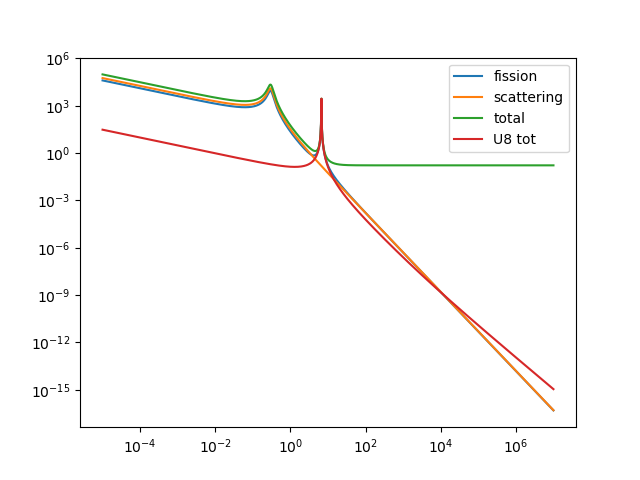

In [4]:

benchmark_e = np.array([0.00001, 0.01000, 0.29562, 6.67425, 100.000, 2.0e7])
# benchmark_e = np.array([6.67425])
energy = np.logspace(-5,7, 1000)
# energy = benchmark_e


pu9_Sig_t, pu9_Sig_f, pu9_Sig_g, pu9_Sig_s = pu9.get_macro_cross_sections(energy)
u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = u8.get_macro_cross_sections(energy)

m_Sig_t, m_Sig_f, m_Sig_g, m_Sig_s = mat.get_macro_cross_sections(energy)


if np.array_equal(energy,benchmark_e):
    print(f'fission:\n {m_Sig_f}')
    print(f'scattering:\n {m_Sig_s}')
    print(f'total:\n {m_Sig_t}')
else:
    figure()
    plot(energy, m_Sig_f, label='fission')
    # plot(energy, mat_gam, label='gamma')
    plot(energy, m_Sig_s, label='scattering')
    plot(energy, m_Sig_t, label='total')

    plot(energy, u8_Sig_t, label='U8 tot')

    xscale('log'); yscale('log')
    legend()

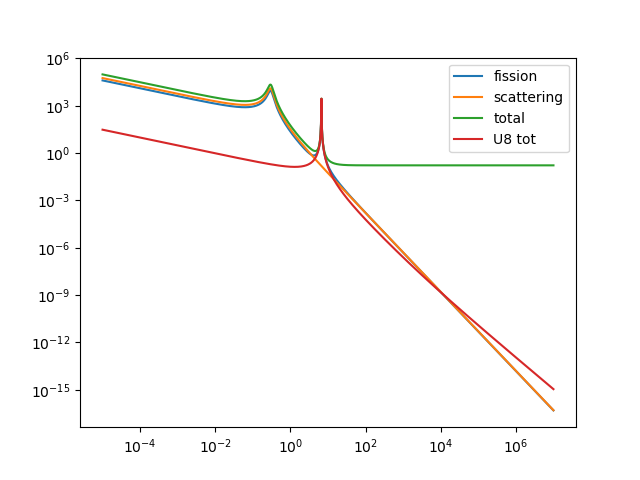

In [5]:
figure()
plot(energy, m_Sig_f, label='fission')
# plot(energy, mat_gam, label='gamma')
plot(energy, m_Sig_s, label='scattering')
plot(energy, m_Sig_t, label='total')

plot(energy, u8_Sig_t, label='U8 tot')

xscale('log'); yscale('log')
legend()

In [6]:
#### problem 4
N = 1.5e2
G=10
iE = 200
print(f'Particle Histories: {N}')
print(f'Energy Bins: {iE}')

Emin = 1e-5
Emax = 2e7 
iEbins = 200
tally = tallies.tallies(Emin, Emax, iEbins)

# option to set seed
rng = np.random.default_rng()

for g in range(int(G)):

    tally.reset_generation_tally()
    
    for iN in range(int(N)):
        #random fission energy
        E_start = rng.uniform(low=tally.Emin, high=tally.Emax) 
        # transport
        E_new = functions_for_transport.Eigen_function_0D_CE(E_start, tally, mat, rng)
    
    # save generation tally
    tally.save_generation_tally(N)
    
   
final_k_estimate, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 

print(final_k_estimate, final_estimator_variance)


Particle Histories: 150.0
Energy Bins: 200
0.968 0.0341355323365732


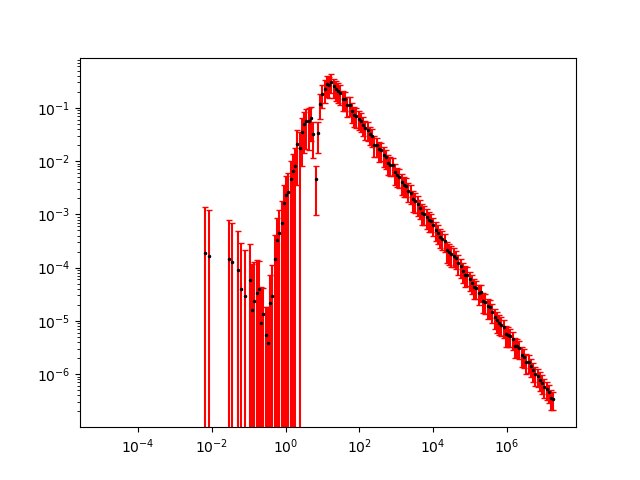

In [7]:

# %%
figure()
errorbar(tally.Ebins, collision_based_scalar_flux[0], yerr=np.sqrt(collision_based_scalar_flux[1]), 
                                                            fmt='.', color='k', ms=3, ecolor='r', capsize=2)

xscale('log')
yscale('log')


In [8]:
tally.first_moment/N

0.78